# Phase 4 Assessment Review

_January 20, 2021_

Agenda Today:
- Principal Component Analysis
- Clustering
- Time Series
- Natural Language Processing

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import seaborn as sns


import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
from itertools import cycle
from bokeh.plotting import output_notebook, output_file, figure, show, ColumnDataSource
from bokeh.models import HoverTool
import warnings
warnings.filterwarnings(action='ignore')
output_notebook()
%matplotlib inline



Loading BokehJS ...

# Part I. PCA

Notes from the Phase 4 Review recording:                    
- dimensionality reduction algo, doesn't reduce dimensions by default
- project original variables to a lower dimension by creating new characteristics called principal components
- PC are linear combinations of the original features
- we can create PCS that explains proportions of variability of original features, see them as cocktails of original features

Characteristics of PCA:
- linearly independent (all PCs), each are not correlated to each other
- eigenvalue - amount of variability explained by each principal component
- eigenvector - direction of the principal components or how much each feature to take to make a particular PC in each direction
- standardized and scaling, lives off on covariance or else covariance will be calculated in the original unit of measurement and can be misleading
- use only with continuous variables
- domain knowledge
- PCs as many as there are original features

### What are some of the advantages using PCA? How does it help reduce dimensions?

- better visualize your data in lower dimensions
- helps with multicollinearity since they are linearly independent
- reduce complexity

In [71]:
# Import the mpg dataset and build pca
mpg = sns.load_dataset('mpg')
# what are some of the steps to build pca?
mpg_cont = mpg.iloc[:,:6]
# step 1 - standardize and scale
mpg_cont.dropna(axis = 0, inplace = True)
X = mpg_cont.drop("mpg", axis=1)
y = mpg_cont.mpg

In [72]:
X.head()

,cylinders,displacement,horsepower,weight,acceleration
0,8,307.0,130.0,3504,12.0
1,8,350.0,165.0,3693,11.5
2,8,318.0,150.0,3436,11.0
3,8,304.0,150.0,3433,12.0
4,8,302.0,140.0,3449,10.5


In [73]:
features = X.columns.to_list()
features

['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']

In [74]:
# step 2 fit our pca - and specify i only want the amount of components that explain 90% of the variance 
sc = StandardScaler()
X_sc = sc.fit_transform(X)
pca = PCA(n_components=0.90)

# fit the pca
# mpg_pca.fit(mpg_scaled)
pc = pca.fit_transform(X_sc)

## Principal Components

In [75]:
df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2'])
target = pd.Series(mpg['mpg'], name='target')
result_df = pd.concat([df, target], axis=1)
result_df.head()

,PC1,PC2,target
0,2.242403,-0.479758,18.0
1,3.035319,-0.599310,15.0
2,2.622952,-0.872521,18.0
3,2.436430,-0.576210,16.0
4,2.493047,-1.024095,17.0


In [76]:
# check out how many components there are 
pca.explained_variance_

array([4.08227378, 0.69563583])

## Eigenvectors and Eigenvalues

In [77]:
eig_values = pca.explained_variance_
eig_vectors = pca.components_ # 2
ls_1 = eig_vectors[0] * np.sqrt(eig_values[0])
ls_2 = eig_vectors[1] * np.sqrt(eig_values[1])
loading = pd.DataFrame(data = {'PC1 Eigenvalues': eig_vectors[0], 'PC2 Eigenvalues': eig_vectors[1], 'PC1 Loading Scores': ls_1, 'PC2 Loading Scores': ls_2}, index=features)
loading

,PC1 Eigenvalues,PC2 Eigenvalues,PC1 Loading Scores,PC2 Loading Scores
cylinders,0.468717,0.223479,0.947027,0.186392
displacement,0.482404,0.178630,0.974681,0.148986
horsepower,0.473844,-0.119989,0.957384,-0.100076
weight,0.461790,0.345286,0.933030,0.287985
acceleration,-0.331379,0.885736,-0.669539,0.738746


In [78]:
eig_vectors

array([[ 0.46871748,  0.4824044 ,  0.47384374,  0.46179021, -0.3313787 ],
       [ 0.2234786 ,  0.17862974, -0.11998855,  0.34528638,  0.8857363 ]])

In [79]:
# how much variance each comp is explaining
print("Amount of Explained Variance: ", np.sum(pca.explained_variance_ratio_))

Amount of Explained Variance:  0.9531442127544515


## Scree Plot

Text(0, 0.5, 'Proportion of explained variance')

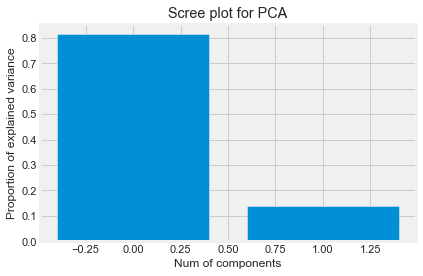

In [80]:
index = np.arange(2)
plt.bar(index, pca.explained_variance_ratio_)
plt.title('Scree plot for PCA')
plt.xlabel('Num of components')
plt.ylabel('Proportion of explained variance')

Text(0, 0.5, 'Cumulative Explained Variance')

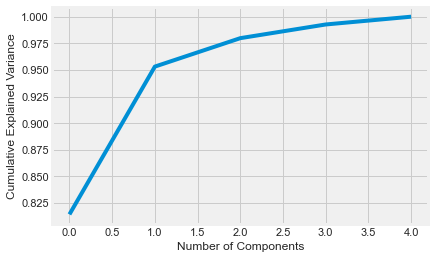

In [81]:
pca = PCA().fit(X_sc)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [82]:
pca = PCA(n_components=2)
pc = pca.fit_transform(X_sc)

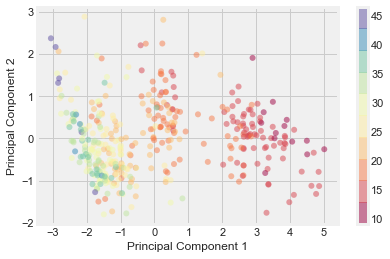

In [83]:
plt.scatter(pc[:, 0], pc[:, 1], c=mpg_cont.mpg, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Conponent 2')
plt.colorbar()

# Part II. Clustering


### Steps of K-Means Clustering:
    1. first we choose k, number of clusters we want to find in data, randomly
    2. in the Reassign Points step, we assign every point in the data to the cluster whose centroid is nearest to it
    3. in the Update Centroids step, we recalculate each centroid's location as the mean (center) of all the points assigned to its cluster
    4. we then iterate these steps until the centroids stop moving, or equivalently until points stop switching clusters.

### How to select the best value of k using those metrics?
    1. silhouette coefficient
        - how good the clusters are 
        - intercluster distance (ideally large) vs. intracluster distance (ideally small)
        - distance between / distance within
        - we want the difference to be large
        - standardized metric from 1 to -1 (good to bad)
    2. elbow method 
        - x-axis have k, y-axis have silhouette score
        - iterate throguh diffeerent values of k
        - for each k value, acquire silhouette score
        - make a graph of elbow method

## Properties of Clustering:

- Despite the fact that k-means is guaranteed to converge, the final cluster configuration to which it converges is not in general unique, and depends on the initial centroid locations. 
- actually possible for no data points to be assigned to a cluster in the Reassign Points step. 
- works best in datasets that have with clusters that are roughly equally-sized and shaped roughly regularly. 
- there is requirement of choosing k, and the dependence of the output on the initial cluster configuration
- can only be applied when the data points lie in a Euclidean space, failing for more complex types of data
- works well on many realistic data sets, and relatively fast, easy to implement and understand
- Many clustering algorithms that improve on or generalize k-means, such as k-medians, k-medoids, k-means++, and EM algorithm for Gaussian mixtures, all reflect the same fundamental insight, that points in a cluster ought to be close to the center of that cluster.

           

### Advantages of K-Means:

1. Removes Correlated Features:

In a real-world scenario, this is very common that you get thousands of features in your dataset. You cannot run your algorithm on all the features as it will reduce the performance of your algorithm and it will not be easy to visualize that many features in any kind of graph. So, you MUST reduce the number of features in your dataset. You need to find out the correlation among the features (correlated variables). Finding correlation manually in thousands of features is nearly impossible, frustrating and time-consuming. PCA does this for you efficiently. After implementing the PCA on your dataset, all the Principal Components are independent of one another. There is no correlation among them.

2. Improves Algorithm Performance: 

With so many features, the performance of your algorithm will drastically degrade. PCA is a very common way to speed up your Machine Learning algorithm by getting rid of correlated variables which don’t contribute in any decision making. The training time of the algorithms reduces significantly with less number of features. So, if the input dimensions are too high, then using PCA to speed up the algorithm is a reasonable choice.

3. Reduces Overfitting: 

Overfitting mainly occurs when there are too many variables in the dataset. So, PCA helps in overcoming the overfitting issue by reducing the number of features.

4. Improves Visualization: 

It is very hard to visualize and understand the data in high dimensions. PCA transforms a high dimensional data to low dimensional data (2 dimension) so that it can be visualized easily. We can use 2D Scree Plot to see which Principal Components result in high variance and have more impact as compared to other Principal Components.

##$ Disadvantages of K-Means:

1. Independent variables become less interpretable:

After implementing PCA on the dataset, your original features will turn into Principal Components. Principal Components are the linear combination of your original features. Principal Components are not as readable and interpretable as original features.

2. Data standardization is must before PCA: 

You must standardize your data before implementing PCA, otherwise PCA will not be able to find the optimal Principal Components. For instance, if a feature set has data expressed in units of Kilograms, Light years, or Millions, the variance scale is huge in the training set. If PCA is applied on such a feature set, the resultant loadings for features with high variance will also be large. Hence, principal components will be biased towards features with high variance, leading to false results. Also, for standardization, all the categorical features are required to be converted into numerical features before PCA can be applied.

PCA is affected by scale, so you need to scale the features in your data before applying PCA. Use StandardScaler from Scikit Learn to standardize the dataset features onto unit scale (mean = 0 and standard deviation = 1) which is a requirement for the optimal performance of many Machine Learning algorithms.

3. Information Loss: 

Although Principal Components try to cover maximum variance among the features in a dataset, if we don’t select the number of Principal Components with care, it may miss some information as compared to the original list of features.

- Hierarchical Clustering (not necessarily on code challenge)

## Types of Clustering:

1. Centroid based clustering:  
    - k-means most widely-used, efficient, but snesitive to initial conditions and outliers
2. Hierarchical Clustering:
    - tree of clusters and suited to hierarchical data such as taxonomies
    - bottom-up approach
    - forms clusters via single, complete, or average linkages
3. Density-based clustering: 
    - connects areas of high example density into clusters
    - allows for arbitrary shaped distributions as long as dense areas can be connected
    - algo do not assign outliers to clusters- difficulty with data of varying densities and high dimensions
4. Distribution-based clustering:
    - assumes data composed of distributions such as Gaussian
    

In [84]:
X.head()

,cylinders,displacement,horsepower,weight,acceleration
0,8,307.0,130.0,3504,12.0
1,8,350.0,165.0,3693,11.5
2,8,318.0,150.0,3436,11.0
3,8,304.0,150.0,3433,12.0
4,8,302.0,140.0,3449,10.5


In [85]:
# building a k-means clustering model - with 3 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_pred = kmeans.predict(X)
# fit the kmeans


In [86]:
X.values

array([[   8. ,  307. ,  130. , 3504. ,   12. ],
       [   8. ,  350. ,  165. , 3693. ,   11.5],
       [   8. ,  318. ,  150. , 3436. ,   11. ],
       ...,
       [   4. ,  135. ,   84. , 2295. ,   11.6],
       [   4. ,  120. ,   79. , 2625. ,   18.6],
       [   4. ,  119. ,   82. , 2720. ,   19.4]])

Text(0.5, 1.0, 'Cylinders vs. Displacement')

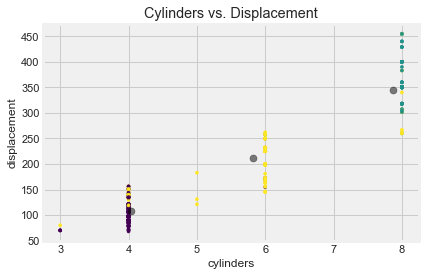

In [87]:
plt.scatter(X.values[:, 0], X.values[:, 1], c=y_pred, s=10, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=50, alpha=0.5)
plt.xlabel("cylinders")
plt.ylabel('displacement')
plt.title("Cylinders vs. Displacement")

Text(0.5, 1.0, 'Horsepower vs. Weight')

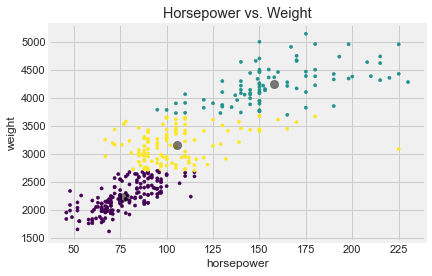

In [88]:
plt.scatter(X.values[:,2], X.values[:,3], c=y_pred, s=10, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:,2], centers[:,3], c='black', s=70, alpha=0.5)
plt.xlabel('horsepower')
plt.ylabel('weight')
plt.title('Horsepower vs. Weight')

In [89]:
# we can get the labels
kmeans.labels_

array([2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1,
       2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2,
       2, 2, 2, 0, 0, 0, 0, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2,
       0, 0, 0, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 2, 1, 0, 0, 0, 0, 2, 1, 2, 2, 0, 0,

In [90]:
from sklearn.metrics import silhouette_score

km_scores = []
km_silhouette = []

for i in range(2, 12):
    km = KMeans(n_clusters=i, random_state=42).fit(X)
    preds = km.predict(X)
    print("Score for number of cluster(s) {}: {}".format(i,km.score(X)))
    km_scores.append(-km.score(X))
    
    silhouette = silhouette_score(X, preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i, silhouette))


Score for number of cluster(s) 2: -72904981.10171562
Silhouette score for number of cluster(s) 2: 0.6367602551968239
Score for number of cluster(s) 3: -33835143.842680335
Silhouette score for number of cluster(s) 3: 0.585383668586636
Score for number of cluster(s) 4: -18798231.8213388
Silhouette score for number of cluster(s) 4: 0.5789671522671691
Score for number of cluster(s) 5: -13484228.314160591
Silhouette score for number of cluster(s) 5: 0.5437216093274108
Score for number of cluster(s) 6: -10140889.193197673
Silhouette score for number of cluster(s) 6: 0.5249922200739212
Score for number of cluster(s) 7: -7576452.265897353
Silhouette score for number of cluster(s) 7: 0.5042026854797601
Score for number of cluster(s) 8: -5602922.849166474
Silhouette score for number of cluster(s) 8: 0.5218876278376178
Score for number of cluster(s) 9: -4666603.193847034
Silhouette score for number of cluster(s) 9: 0.510321772421966
Score for number of cluster(s) 10: -3978529.585229514
Silhouette

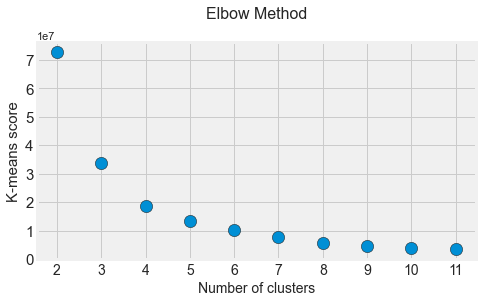

In [91]:
plt.figure(figsize=(7,4))
plt.title("Elbow Method\n", fontsize=16)
plt.scatter(x=[i for i in range(2,12)], y=km_scores, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters", fontsize=14)
plt.ylabel("K-means score", fontsize=15)
plt.xticks([i for i in range(2,12)], fontsize=14)
plt.yticks(fontsize=15)
plt.show()

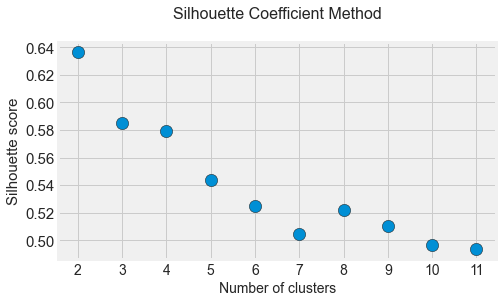

In [92]:
plt.figure(figsize=(7,4))
plt.title("Silhouette Coefficient Method\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)], y=km_silhouette, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters", fontsize=14)
plt.ylabel("Silhouette score", fontsize=15)
plt.xticks([i for i in range(2,12)], fontsize=14)
plt.yticks(fontsize=15)
plt.show()

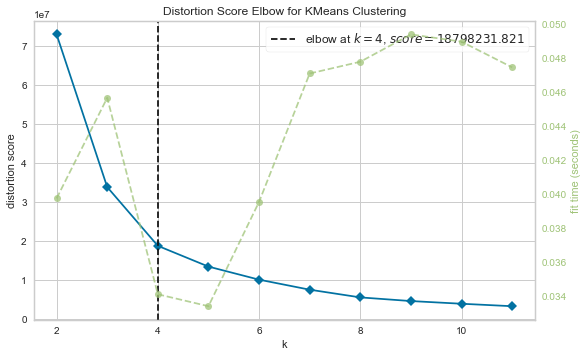

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [93]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,12)).fit(X)
visualizer.show()

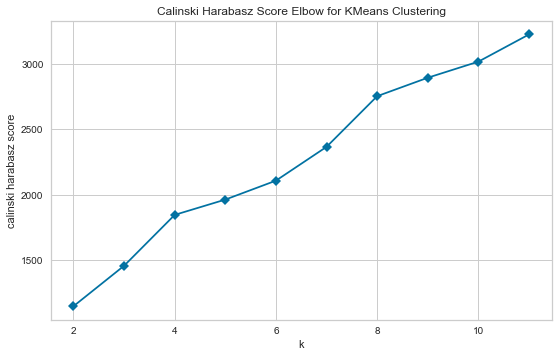

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [94]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz', timings=False).fit(X)
visualizer.show()   

# Part III. Natural Language Processing 
- What are some of the ways in which we can engineer features in NLP?



- What is TF-IDF, how is it calculated? What does it represent?

## TF-IDF Conceptual Understanding

- term frequency multiplified by how common term is in corpus
- TF = term frequency, how times token shows up in document (importance)
- IDF = inverse document frequency, take ratio of total number of documents / number of documents containing a token w and take the log of that (unique)
    - if w is unique and uncommon, IDF goes up, so high IDF value means more importance and more unique
    - if word is unique, w and denominator is smaller, ratio is larger, hence IDF is larger
    - if word is not unique, w and denominator is larger, ratio is smaller, hence IDF is smaller
    - log is to bring the range of values into more manageable balues
- TF/IDF 
    - harmonic measure of both of those things
    - high only if both are high
    - means that word is important and unique

In [24]:
# instantiate some data 
review_1 = "6/10 Acting, not great but some good acting.<br /><br />4/10 Director, makes some stupid decisions for this film.<br /><br />2/10 Writer, story makes no sense at all and has huge amount of flaws.<br /><br />4/10 Overall score for this movie.<br /><br />Don't waste your time with this film, it's not worth it. I gave 4 for this movie and it may be too much. Characters are so over exaggerated than they can ever be in real life and some pretty unexplainable stuff happens 'storywise', not in good way. Because of the style this film has been filmed you get bored after 30 minutes (too many special effects: slow motions and camera shakes and fast forwards). It's always good that movie uses music to make the story go smooth but there's too many tracks in this one. In the first hour there is almost 50/50 dialogs and musics"
review_2 = "Devil Hunter gained notoriety for the fact that it's on the DPP 'Video Nasty' list, but it really needn't have been. Many films on the list where there for God (and DPP) only known reasons, and while this isn't the tamest of the bunch; there isn't a lot here that warrants banning...which is a shame because I never would have sat through it where it not for the fact that it's on 'the shopping list'. The plot actually gives the film a decent base - or at least more of a decent base than most cannibal films - and it follows an actress who is kidnapped and dragged off into the Amazon jungle. A hunter is then hired to find her, but along the way he has to brave the natives, lead by a man who calls himself 'The Devil' (hence the title). The film basically just plods along for eighty five minutes and there really aren't many scenes of interest. It's a real shame that Jess Franco ended up making films like this because the man clearly has talent; as seen by films such as The Diabolical Dr Z, Venus in Furs, Faceless and She Kills in Ecstasy, but unfortunately his good films are just gems amongst heaps of crap and Devil Hunter is very much a part of the crap. I saw this film purely because I want to be able to say I've seen everything on the DPP's list (just two more to go!), and I'm guessing that's why most other people who have seen it, saw it. But if you're not on the lookout for Nasties; there really is no reason to bother with this one."
review_3 = "`Stanley and Iris' is a heart warming film about two people who find each other and help one another overcome their problems in life. Stanley's life is difficult, because he never learned to read or write. Iris is a widower with two teenage children working in a bakery where she meets Stanley. She decides to teach Stanley how to read at her home in her spare time. Over time they become romantically involved. After Stanley learns to read, he goes off to a good job in Chicago, only to return to Iris and ask her to marry him.<br /><br />It's a really good film without nudity, violence, or profanity, that which is rare in today's films. A good film all round. <br /><br />"
review_4 = "This may not be a memorable classic, but it is a touching romance with an important theme that stresses the importance of literacy in modern society and the devastating career and life consequences for any unfortunate individual lacking this vital skill.<br /><br />The story revolves around Iris, a widow who becomes acquainted with a fellow employee at her factory job, an illiterate cafeteria worker named Stanley. Iris discovers that Stanley is unable to read, and after he loses his job, she gives him reading lessons at home in her kitchen. Of course, as you might predict, the two, although initially wary of involvement, develop feelings for each other...<br /><br />Jane Fonda competently plays Iris, a woman with problems of her own, coping with a job lacking prospects, two teenage children (one pregnant), an unemployed sister and her abusive husband. However, Robert DeNiro is of course brilliant in his endearing portrayal of the intelligent and resourceful, but illiterate, Stanley, bringing a dignity to the role that commands respect. They aren't your typical charming young yuppie couple, as generally depicted in on screen romances, but an ordinary working class, middle aged pair with pretty down to earth struggles.<br /><br />I won't give the ending away, but it's a lovely, heartwarming romance and a personal look into the troubling issue of adult illiteracy, albeit from the perspective of a fictional character."

labels = [0,1,1,0]
df = pd.DataFrame([review_1, review_2, review_3, review_4], columns=['review'])
df['label'] = labels

In [25]:
df.head()

,review,label
0,"6/10 Acting, not great but some good acting.<b...",0
1,Devil Hunter gained notoriety for the fact tha...,1
2,`Stanley and Iris' is a heart warming film abo...,1
3,"This may not be a memorable classic, but it is...",0


In [26]:
# define our x and y
X = df.review
y = df.label

In [27]:
# what are some of the steps to engineer the features?

# stop words removal
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

# what if you need to remove more stopwords than this collection?
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


# use tfidf, with unigrams and bigrams, and remove stop words
tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords_list)
# 1, 2 for unigram and bigram

## could you add some optional parameters to that?


## Parameters for TdidfVectorizer

### stopwords
In my code, I used python stopwords=None but python stopwords='english' is available. This setting will filter out words using a preselected list of high frequency function words such as ‘the’, ‘to’, and ‘of’. Depending on your settings, many of these terms will have low tf-idf scores regardless because they tend to be found in all documents. For a discussion of some publicly available stop word lists (including Scikit-Learn’s), see “Stop Word Lists in Free Open-source Software Packages”.

### max_df and min_df
These settings control the minimum number of documents a term must be found in to be included and the maximum number of documents a term can be found in in order to be included. Either can be expressed as a decimal between 0 and 1 indicating the percent threshold, or as a whole number that represents a raw count. Setting max_df below .9 will typically remove most or all stopwords.

### max_features
This parameter can be used to winnow out terms by frequency before running tf-idf. It can be especially useful in a machine learning context when you do not wish to exceed a maximum recommended number of term features.

### norm, smooth_idf, and sublinear_tf
Each of these will affect the range of numerical scores that the tf-idf algorithm outputs. norm supports l1 and l2 normalization, which you can read about on machinelearningmastery.com. Smooth-idf adds one to each document frequency score, “as if an extra document was seen containing every term in the collection exactly once.” Sublinear_tf applies another scaling transformation, replacing tf with log(tf). For more on tf-idf smoothing and normalization, see Manning, Raghavan, and Schütze.

## CountVectorizer

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
# ngram_range allows us to check for any range on n-grams, can also give stop works and a tokenizer
cv = CountVectorizer(lowercase=True, stop_words=stopwords_list, ngram_range = (1,2), tokenizer = token.tokenize)
text_counts = cv.fit_transform(df['review'])
text_counts

<4x688 sparse matrix of type '<class 'numpy.int64'>'
	with 731 stored elements in Compressed Sparse Row format>

In [29]:
text_counts.data

array([4, 2, 1, 3, 8, 1, 2, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1,
       3, 3, 1, 1, 2, 3, 1, 1, 4, 3, 5, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [30]:
df_vectors = pd.DataFrame(text_counts.toarray(), columns = cv.get_feature_names())
df_vectors

,10,10 acting,10 director,10 overall,10 writer,30,30 minutes,50,50 50,50 dialogs,...,write,write iris,writer,writer story,young,young yuppie,yuppie,yuppie couple,z,z venus
0,4,1,1,1,1,1,1,2,1,1,...,0,0,1,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,0,0


## Modeling

In [31]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
tv = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords_list)

In [32]:
# step 1 - train test split
X = df.review
X_tr, X_tt, y_tr, y_tt = train_test_split(X, y, test_size=0.20, random_state=42)

# step 2 - tokenize and feature engineer using tfidf
tv_fitted = tv.fit(X_tr)
train_feat = tv_fitted.transform(X_tr)
test_feat = tv.transform(X_tt)

# step 3 - fit the model to the training set, test the model on the testing set
classifier = RandomForestClassifier()
classifier.fit(train_feat, y_tr)

# step 4 - output prediction on testing set, compare true labels to predicted labels, get accuracy
pred = classifier.predict(test_feat)

In [33]:
pd.DataFrame(train_feat.todense())

,0,1,2,3,4,5,6,7,8,9,...,476,477,478,479,480,481,482,483,484,485
0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059311,0.059311,0.059311,0.059311
1,0.26903,0.067258,0.067258,0.067258,0.067258,0.067258,0.067258,0.134515,0.067258,0.067258,...,0.067258,0.067258,0.000000,0.000000,0.067258,0.067258,0.000000,0.000000,0.000000,0.000000
2,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.080625,0.080625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
idf = tv.idf_

In [35]:
results = dict(zip(tv_fitted.get_feature_names(), idf))
token_wt = pd.DataFrame.from_dict(results, orient='index').reset_index()
token_wt.columns=('token', 'weight')
token_wt = token_wt.sort_values(by="weight", ascending=False)
token_wt.iloc[0:10]


,token,weight
0,10,1.693147
313,people,1.693147
325,pregnant,1.693147
324,predict two,1.693147
323,predict,1.693147
322,portrayal intelligent,1.693147
321,portrayal,1.693147
320,plays iris,1.693147
319,plays,1.693147
318,perspective fictional,1.693147


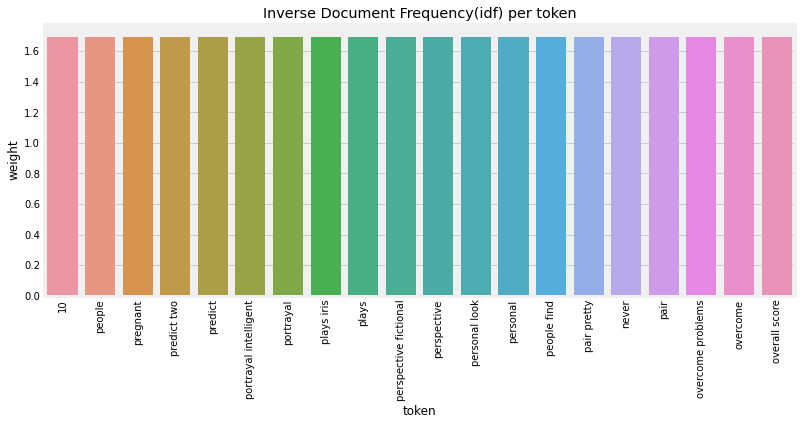

In [38]:
sns.barplot(x="token", y='weight', data=token_wt.iloc[0:20])
plt.title("Inverse Document Frequency(idf) per token")
fig = plt.gcf()
fig.set_size_inches(12,5)
plt.xticks(rotation = 90)
plt.show()

In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(pred, y_tt)

0.0

## Part IV. Time Series

In [40]:
ts = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')

In [41]:
ts.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [42]:
# convert the date to datetime 
ts.Date = pd.to_datetime(ts.Date)

# your code below



In [43]:
# set the index to date
ts.set_index('Date', inplace=True)

- White Noise Model:
    - true stationary process, like monthly NYS returns
    - 3 properties:
        1. fixed and constant mean
        2. fixed and constant variance
        3. no correlation over time
- Random Walk Model:
    - no specified mean or variance
    - strong dependence over time
    - exchange rates

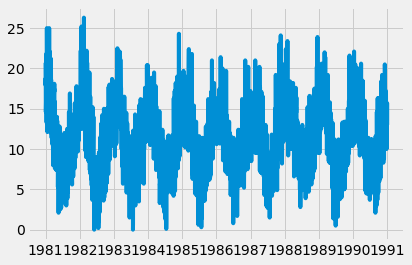

In [57]:
# visualize the daily temperature 
#visualize the daily temperature 
plt.plot(ts['Temp'])

In [50]:
sns.set_style('whitegrid')

<AxesSubplot:xlabel='Date', ylabel='Temp'>

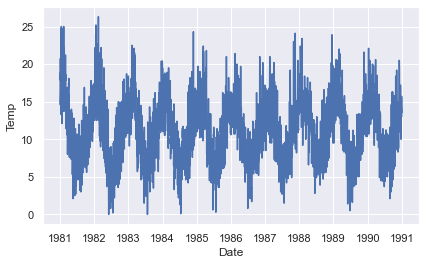

In [61]:
sns.lineplot(data = ts.Temp)

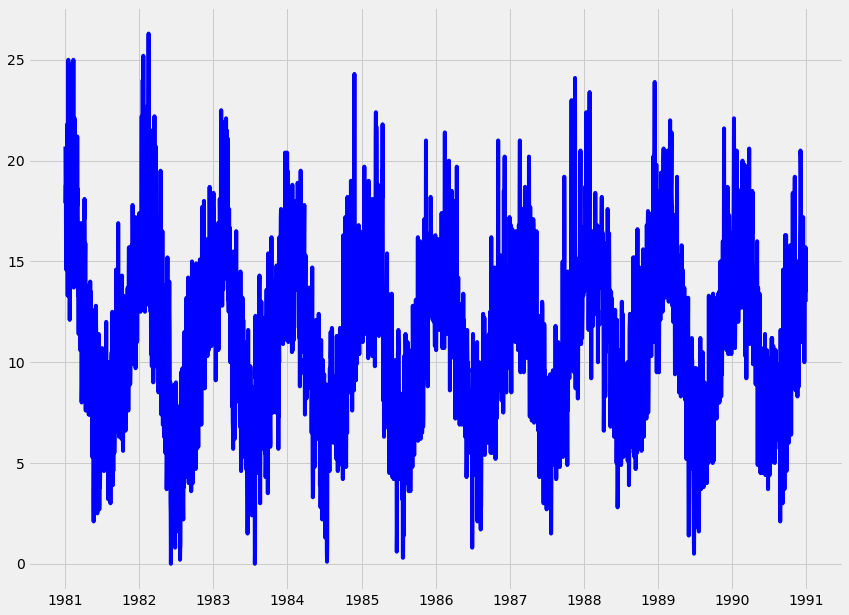

In [58]:
fig, ax = plt.subplots(figsize=(13, 10))
ax.plot(ts['Temp'], color='blue',label='daily opening stock price')

In [55]:
# get only the monthly mean 
monthly = ts.resample('M').mean()

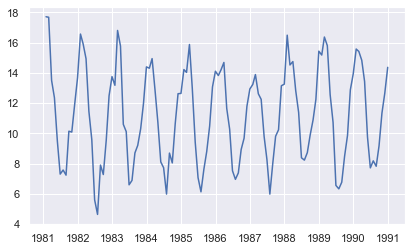

In [56]:
# visualize monthly mean
plt.plot(monthly['Temp'])

<AxesSubplot:xlabel='Date', ylabel='Temp'>

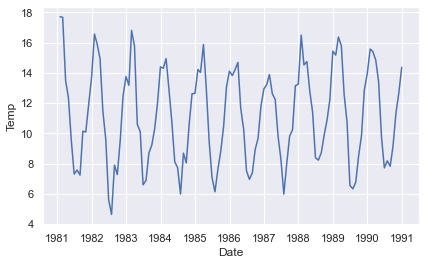

In [63]:
sns.lineplot(data = monthly['Temp'])

- is there stationarity in the monthly mean?
    - assumption that model has constant mean and variance and covariance

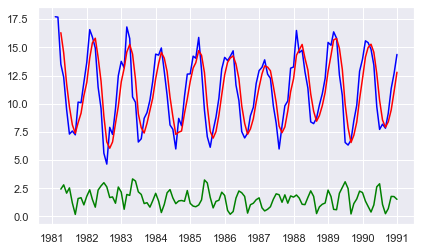

In [57]:
# get the rrolling mean, rolling standard deviation, and visualize all three of them together
roll_mean = monthly.rolling(window = 3).mean()
roll_std = monthly.rolling(window = 3).std()
plt.plot(monthly['Temp'], color = 'blue')
plt.plot(roll_mean, color = 'red')
plt.plot(roll_std, color = 'green')


[]

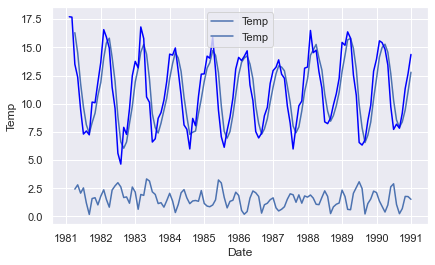

In [69]:
sns.set_theme(style='darkgrid')
g = sns.lineplot(data=roll_std, color='green')
g = sns.lineplot(data=roll_mean, color='red')
g = `sns.lineplot(data=monthly['Temp'], color='blue')
g.plot()

- rolling mean and std
    - every three days we calculate a mean or standard deviation, it's a smoothing method
    - optional parameter of how many days in the window

In [64]:
# do a dickey fuller test to find out whether our dataset is stationary or not
from statsmodels.tsa.stattools import adfuller
test = adfuller(monthly['Temp'])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                  -1.892313
p-value                          0.335686
#Lags Used                      13.000000
Number of Observations Used    106.000000
dtype: float64


- what are some of the assumptions of using arima model? 
- does our dataset satisfy this assumption?
    - equal interval of observations
    - stationarity: constant mean, variance, covariance
- what kind of test can you use to find out?
- null hypothesis is there is no stationarity
    - we want to reject the null hypothesis since p-value is greater than .05
    - p value is too high, and our data does not have stationarity
- looks like it has stationarity, but according to the DF test there isn't stationarity

In [30]:
t = pd.read_csv('data/global_surface_temperature_anomalies.csv')
e = pd.read_csv('data/global_co2_emissions_per_capita.csv')
s = pd.read_csv("data/fundamentals.csv")

In [8]:
t.head()

,date,Avg_Anomaly_deg_C
0,1880-01-31,-0.29
1,1880-02-29,-0.18
2,1880-03-31,-0.11
3,1880-04-30,-0.19
4,1880-05-31,-0.11


In [9]:
e.head()

,date,Global CO2 Emissions per Capita
0,1960-12-31,3.099013
1,1961-12-31,3.069727
2,1962-12-31,3.140511
3,1963-12-31,3.244499
4,1964-12-31,3.360596


In [13]:
import datetime

In [14]:
t.date = pd.to_datetime(t.date)
e.date = pd.to_datetime(e.date)
t.set_index('date', inplace=True)
e.set_index('date', inplace=True)

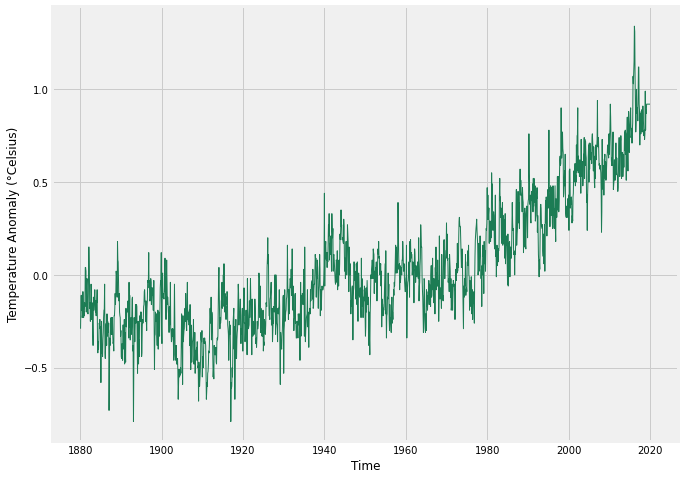

In [23]:
# Create figure, title and plot data
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°C)')
plt.plot(t, color='#1C7C54', linewidth=1.0)

In [36]:
t_mean = t.resample('A').mean()
t_mean.head()

,Avg_Anomaly_deg_C
date,
1880-12-31,-0.185000
1881-12-31,-0.095000
1882-12-31,-0.101667
1883-12-31,-0.185000
1884-12-31,-0.288333


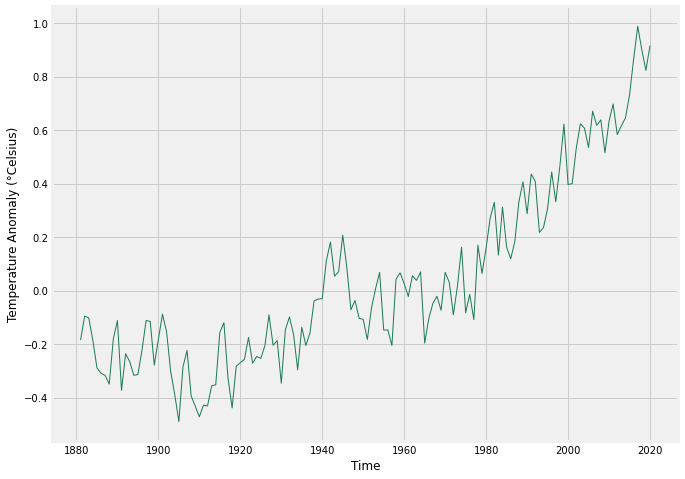

In [25]:
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°Celsius)')
plt.plot(t.resample('A').mean(), color='#1C7C54', linewidth=1.0)

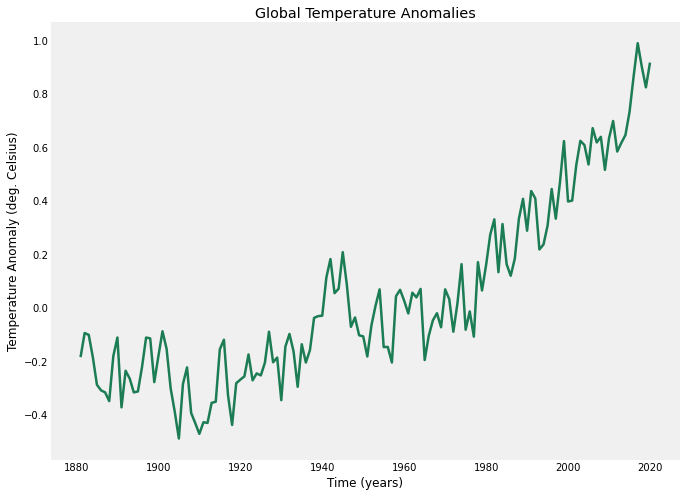

In [26]:
t_resampled = t.resample('A').mean()
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(t_resampled, color='#1C7C54', linewidth=2.5)
ax.set(xlabel='Time (years)', ylabel='Temperature Anomaly (deg. Celsius)',
       title='Global Temperature Anomalies')
ax.grid()


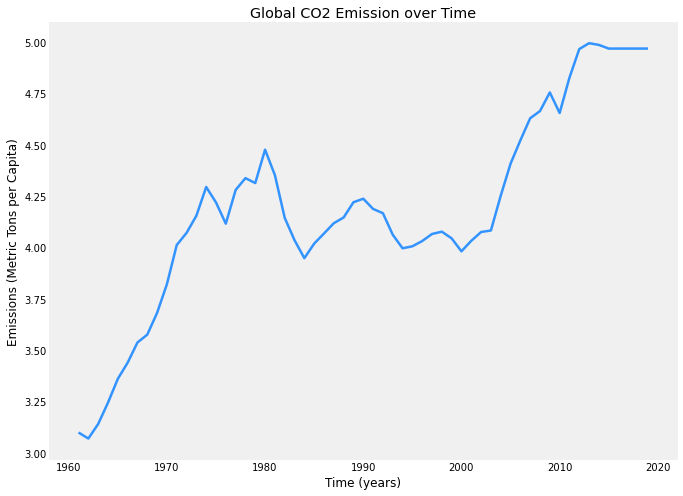

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(e, color='#3393FF', linewidth=2.5)
ax.set(xlabel='Time (years)', ylabel='Emissions (Metric Tons per Capita)',
       title='Global CO2 Emission over Time')
ax.grid()

In [32]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mod
import cufflinks as cf
cf.go_offline(connected=True)
init_notebook_mode(connected=True)

In [33]:
t.resample('A').mean().iplot(kind='line', xTitle='Time (years)', color='#1C7C54',
                  yTitle='Temperature Anomaly (deg. Celsius)', title='Global Temperature Anomalies')

In [34]:
e.iplot(kind='line', xTitle='Time (years)', color='#3393FF',
                  yTitle='Emissions (Metric Tons per Capita)', title='Global CO2 Emission over Time')

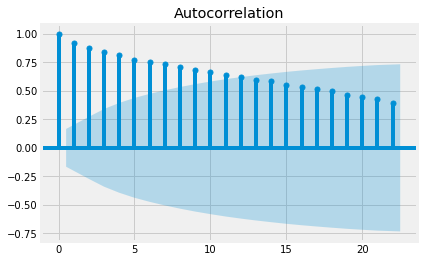

In [40]:
import statsmodels.api as sm

_ = sm.graphics.tsa.plot_acf(t_mean)
plt.show()


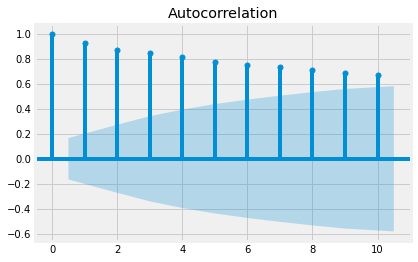

In [41]:
_ = sm.graphics.tsa.plot_acf(t_mean, lags=10)

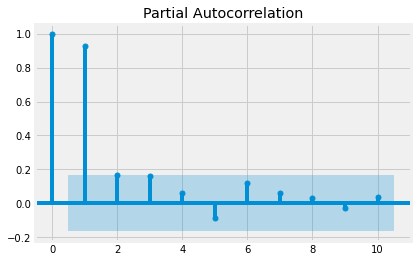

In [42]:
_ = sm.graphics.tsa.plot_pacf(t_mean, lags=10)